In [60]:
#-*- coding:utf-8 -*-

# HW_0918 Regression 학습 모델 및 예측 진행 (이태헌)
## 1. Data Set
#####   - 자동차의 가격, 정비비용, 도어수, 인원수, 트렁크 크기, 안전도에 따라 4개의 추천 등급으로 나눔
#####   - 추천 등급 분포(unacc: 70%, acc: 22.2%, good: 4%, very good: 3.7%)에 따라 
#####        training과 test에 동일 분포를 가지도록 인위적으로 data를 정리하여
#####        각각 0918_car_training.csv(1385개), 0918_car_test.csv(343개) 파일로 사전 준비함
## 2. 진행
#####   - 1차로 기존 수업에서 진행된 방식을 따라함
#####   - Normalization, Modeling, Training, Prediction Plotting 진행
#####   - 기본 진행 후 Early stop을 통한 training 감소 확인함
## 3. 도전
#####   - 수업 중 진행된 One-hot 인코딩 방식이 향후 쓸모가 많을 것이라 생각하여 추가 진행함
#####   - 숫자로 적용된 4개의 추천등급을 4개 category로 나누어서 마지막 layer 출력을 4개로 설정하고 진행함
#####   - Label의 수가 4개로 늘어났으므로 그대로 기존 진행한 Prediction plotting을 통해 결과를 확인해보고,
#####   - 4개 Label을 하나의 값(최초 추천등급)으로 정리하여 일치 여부에 따른 정확도 확인함(정확도 81%).
## 4. 계획
#####   - 추가로 softmax를 활용한 modeling이 효과적이라고 판단되어 진행해볼 예정임

In [59]:
import os
import sys
import pathlib
import numpy as np
import time

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

In [2]:
print (os.getcwd())

C:\ProjectSky\AI_KAIST\HW_0918_MLP_BP


In [4]:

try:
	os.chdir(os.path.join(os.getcwd(), 'AI_KAIST\\HW_0918_MLP_BP'))
	print(os.getcwd())
except:
	pass


 ## =======================================================
 ## 1. Regeression Modeling, Training, Prediction 진행
 ## =======================================================

### 1-1 데이터 가져오기 < Car Score Data >

In [5]:
## Getting Data ##
trainfilepath = os.path.join(os.getcwd(), '0918_car_train.csv')
testfilepath = os.path.join(os.getcwd(), '0918_car_test.csv')
traindata = pd.read_csv(trainfilepath)
testdata = pd.read_csv(testfilepath)

colNames = [ x for x in traindata.columns ]
print ('colNames :', colNames)


colNames : ['Price', 'Maintenance', 'Doors', 'Persons', 'Luggage', 'Safety', 'Score']


### 1-2 Train set / Test set 지정하기

In [30]:

features = ['Price','Maintenance','Doors','Persons','Luggage','Safety']
labels = ['Score']


train_dataset = traindata.loc[:,features]
test_dataset = testdata.loc[:,features]

train_labels = traindata.loc[:,labels]
test_labels = testdata.loc[:,labels]


### 1-3 Train set, Test set 확인하기

In [7]:

train_dataset.head(),test_dataset.head(),train_labels.head(),test_labels.head()


(   Price  Maintenance  Doors  Persons  Luggage  Safety
 0      4            4      2        2        1       1
 1      4            4      2        2        1       2
 2      4            4      2        2        1       3
 3      4            4      3        2        1       1
 4      4            4      3        2        1       2,
    Price  Maintenance  Doors  Persons  Luggage  Safety
 0      1            4      2        5        2       2
 1      1            4      2        5        3       1
 2      1            4      3        2        1       1
 3      1            4      3        2        1       2
 4      1            4      3        2        1       3,
    Score
 0      1
 1      1
 2      1
 3      1
 4      1,
    Score
 0      1
 1      1
 2      1
 3      1
 4      1)

### 1-4 Train/Test set Label 분포 확인

In [8]:
train_labels.describe(),test_labels.describe()

(             Score
 count  1385.000000
 mean      1.414440
 std       0.740114
 min       1.000000
 25%       1.000000
 50%       1.000000
 75%       2.000000
 max       4.000000,             Score
 count  343.000000
 mean     1.416910
 std      0.744143
 min      1.000000
 25%      1.000000
 50%      1.000000
 75%      2.000000
 max      4.000000)

### 1-5 Normalization을 위한 Mean, std 확보

In [9]:
trainStatus = train_dataset.describe().transpose()
trainStatus['mean'],trainStatus['std']

(Price          2.871480
 Maintenance    2.515523
 Doors          3.470036
 Persons        3.701805
 Luggage        2.011552
 Safety         2.033935
 Name: mean, dtype: float64, Price          0.930040
 Maintenance    1.115419
 Doors          1.123516
 Persons        1.234688
 Luggage        0.816120
 Safety         0.817707
 Name: std, dtype: float64)

### 1-6 Data Normalization

In [10]:
def normalizeData(x):
	return (x - trainStatus['mean']) / trainStatus['std']

normalized_train_data = normalizeData(train_dataset)
normalized_test_data = normalizeData(test_dataset)
normalized_train_data.head()

,Price,Maintenance,Doors,Persons,Luggage,Safety
0,1.213411,1.330869,-1.308425,-1.378328,-1.239466,-1.264432
1,1.213411,1.330869,-1.308425,-1.378328,-1.239466,-0.041500
2,1.213411,1.330869,-1.308425,-1.378328,-1.239466,1.181431
3,1.213411,1.330869,-0.418362,-1.378328,-1.239466,-1.264432
4,1.213411,1.330869,-0.418362,-1.378328,-1.239466,-0.041500


### 1-7 Build Model

In [11]:
def build_model():
	model = keras.Sequential([\
		layers.Dense(64, activation=tf.nn.relu, input_shape=[6]),\
		layers.Dense(64, activation=tf.nn.relu),\
		layers.Dense(1)
	])
	optimizer = tf.keras.optimizers.RMSprop(0.001)
	model.compile(loss='mean_squared_error', \
                  optimizer=optimizer, metrics=['mean_absolute_error', 'mean_squared_error'])
	return model

In [12]:
model = build_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### 1-8 Model 확인, Example 실행

In [13]:
model.summary()
example_batch = normalized_train_data[:10]
example_result = model.predict(example_batch)
example_result

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


array([[-0.11434855],
       [-0.11593141],
       [-0.21094304],
       [ 0.03430163],
       [-0.02892515],
       [-0.1028904 ],
       [ 0.07632117],
       [ 0.03121991],
       [ 0.01748413],
       [ 0.0540667 ]], dtype=float32)

### 1-9 Training 진행

In [14]:
class PrintDot(keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs):
		if epoch % 100 == 0: print('')
		print ('.', end='')
        
time_start = time.time()
EPOCHS = 1000

history = model.fit( normalized_train_data, train_labels, \
	epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[PrintDot()])

print ('\n\nDone. Training Time : %0.3fs' %(time.time()-time_start))


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

### 1-10 정확도 확인

In [15]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,0.000814,0.019891,0.000814,0.343437,0.441562,0.343437,995
996,0.001057,0.021075,0.001057,0.279270,0.401469,0.279270,996
997,0.000695,0.018256,0.000695,0.295706,0.405610,0.295706,997
998,0.000996,0.021370,0.000996,0.297725,0.407346,0.297725,998
999,0.000815,0.019869,0.000815,0.333591,0.428172,0.333591,999


In [16]:
import matplotlib.pyplot as plt

def plot_history(history):
	hist = pd.DataFrame(history.history)
	hist['epoch'] = history.epoch

	plt.figure(figsize=(8,12))

	plt.subplot(2,1,1)
	plt.xlabel('Epoch')
	plt.ylabel('Mean Abs Error')
	plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
	plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label = 'Val Error')
	plt.ylim([0,0.8])
	plt.legend()

	plt.subplot(2,1,2)
	plt.xlabel('Epoch')
	plt.ylabel('Mean Square Error')
	plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
	plt.plot(hist['epoch'], hist['val_mean_squared_error'], label = 'Val Error')
	plt.ylim([0,1])
	plt.legend()
	plt.show()


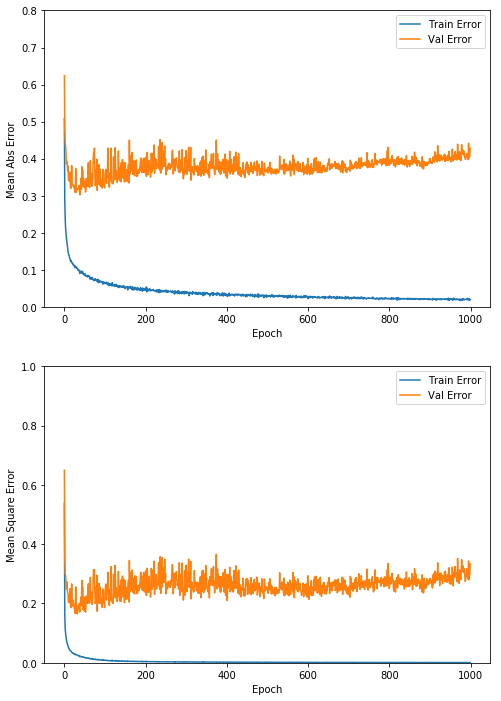

In [17]:
plot_history(history)

### 1-11 Early Stop을 적용한 Training 횟수 줄이기


...................................

Done. Training Time : 0.000s


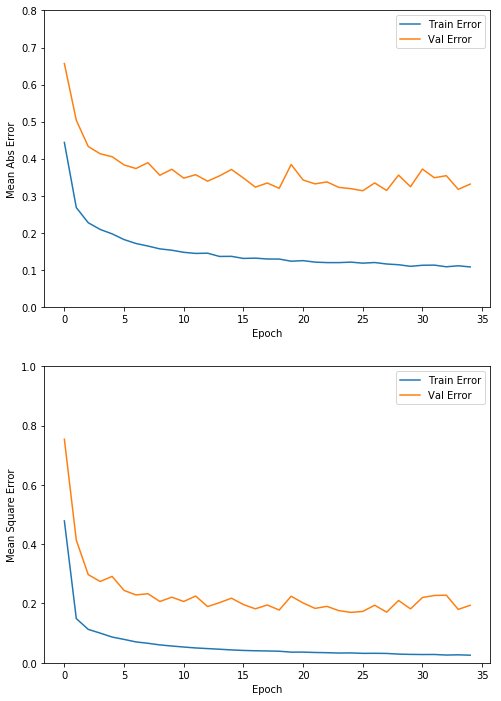

In [20]:
model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normalized_train_data, train_labels, epochs=EPOCHS,\
	validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

time_start = time.time()	
print ('\n\nDone. Training Time : %0.3fs' %(time.time()-time_start))
plot_history(history)

### 1-12 Test set 적용 예측 결과

In [24]:
loss, mae, mse = model.evaluate(normalized_test_data, test_labels, verbose=0)
print("테스트 세트의 평균 절대 오차: {:5.2f} ".format(mae))

테스트 세트의 평균 절대 오차:  0.38 


### 1-13 예측 결과 비교 Plotting (오차분포확인)

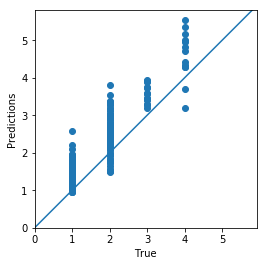

In [26]:
test_predictions = model.predict(normalized_test_data).flatten()

plt.scatter(test_labels.loc[:,'Score'], test_predictions)
plt.xlabel('True')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.plot([-100,100], [-100,100])

# ## =======================================================
# ## 2. Classification 으로 전환하여 Model 학습 및 예측 진행해보기
# ## =======================================================

### 2-1 Train, Test Label data를 One-hot encoding으로 변환

In [33]:
import copy

train_labels_cls = copy.deepcopy(train_labels)
test_labels_cls = copy.deepcopy(test_labels)

train_labels_cls['unacc'] = (train_labels_cls['Score'] == 1)*1.0
train_labels_cls['acc'] = (train_labels_cls['Score'] == 2)*1.0
train_labels_cls['good'] = (train_labels_cls['Score'] == 3)*1.0
train_labels_cls['vgood'] = (train_labels_cls['Score'] == 4)*1.0

test_labels_cls['unacc'] = (test_labels_cls['Score'] == 1)*1.0
test_labels_cls['acc'] = (test_labels_cls['Score'] == 2)*1.0
test_labels_cls['good'] = (test_labels_cls['Score'] == 3)*1.0
test_labels_cls['vgood'] = (test_labels_cls['Score'] == 4)*1.0

_ = train_labels_cls.pop('Score')
_ = test_labels_cls.pop('Score')

In [41]:
train_labels_cls.tail()

,unacc,acc,good,vgood
1380,0.0,0.0,0.0,1.0
1381,0.0,0.0,0.0,1.0
1382,0.0,0.0,0.0,1.0
1383,0.0,0.0,0.0,1.0
1384,0.0,0.0,0.0,1.0


In [43]:
test_labels_cls.tail()

,unacc,acc,good,vgood
338,0.0,0.0,0.0,1.0
339,0.0,0.0,0.0,1.0
340,0.0,0.0,0.0,1.0
341,0.0,0.0,0.0,1.0
342,0.0,0.0,0.0,1.0


### 2-2 Modeling 진행 (Label이 4개므로 마지막 layer는 4로 설정)

In [44]:
def build_model2():
	model = keras.Sequential([\
		layers.Dense(64, activation=tf.nn.relu, input_shape=[6]),\
		layers.Dense(64, activation=tf.nn.relu),\
		layers.Dense(4, activation=tf.nn.relu)
	])

	optimizer = tf.keras.optimizers.RMSprop(0.001)

	if True:
		model.compile(loss='mean_squared_error', \
			optimizer=optimizer, metrics=['mean_absolute_error', 'mean_squared_error'])

	else:
		model.compile(loss='sparse_categorical_crossentropy', \
			optimizer=optimizer, metrics=['accuracy'])

	return model

model2 = build_model2()

model2.summary()

example_batch = normalized_train_data[:10]
example_result = model2.predict(example_batch)
example_result


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 260       
Total params: 4,868
Trainable params: 4,868
Non-trainable params: 0
_________________________________________________________________


array([[0.        , 0.        , 0.09269381, 0.        ],
       [0.        , 0.        , 0.00197591, 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.15515476, 0.        ],
       [0.        , 0.        , 0.01203351, 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.10616836, 0.00155536],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.04749221],
       [0.        , 0.        , 0.01251993, 0.11079945]], dtype=float32)

### 2-3 Build Model


.........................

Done. 0.000s


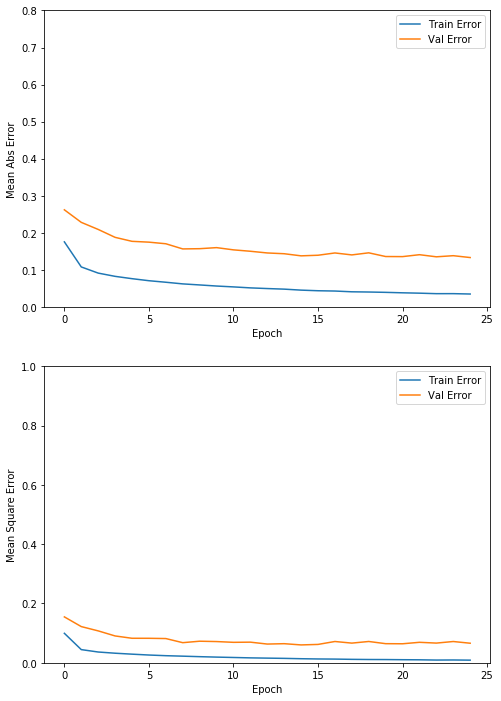

In [45]:
EPOCHS = 1000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model2.fit(normalized_train_data, train_labels_cls, epochs=EPOCHS,\
	validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

time_start = time.time()	
print ('\n\nDone. %0.3fs' %(time.time()-time_start))
plot_history(history)

### 2-4 Test set 적용 예측 결과

In [48]:
loss, mae, mse = model2.evaluate(normalized_test_data, test_labels_cls, verbose=0)
print("테스트 세트의 평균 절대 오차: {:5.2f} ".format(mae))

테스트 세트의 평균 절대 오차:  0.14 


### 2-5 One-hot 인코딩으로 나눈 것을 다시 Score label로 변경함

In [49]:
import numpy as np

test_predictions = model2.predict(normalized_test_data)#.flatten()

## 각각의 예측값을 합친 값
test_predictions_cls = 1*test_predictions[:,0] + 2*test_predictions[:,1] \
	+ 3*test_predictions[:,2] + 4*test_predictions[:,3]

## 최대 값을 가진 label 기준으로 Score 설정
test_predictions_cls2 = np.argmax(test_predictions, axis=1) + 1 

### 2-6 예측한 값을 Score 값으로 변경하여 관측값이 얼마나 일치하는 확인하는 방식으로 정확도 체크

In [56]:
test_labels_cls['Score'] = 1*test_labels_cls['unacc'] + 2*test_labels_cls['acc'] \
	+ 3*test_labels_cls['good'] + 4*test_labels_cls['vgood']

chkarr = test_labels_cls['Score'] - test_predictions_cls2

cnt = 0
for c in chkarr:
	if int(c) == 0:
		cnt += 1

print ('Accuracy of Score : %0.3f ' %(cnt / len(chkarr)))

Accuracy of Score : 0.810 


### 2-7 예측값들을 다 합쳐서 실제 Score 관측값과 비교하여 plotting

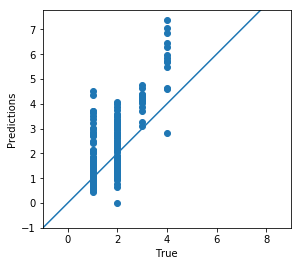

In [58]:
plt.scatter(test_labels_cls.loc[:,'Score'], test_predictions_cls)
plt.xlabel('True')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([-1,plt.xlim()[1]])
plt.ylim([-1,plt.ylim()[1]])
plt.plot([-100,100], [-100,100])